In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from pic_utils import *

In [50]:
trainNum = 400
testNum = 100

In [51]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_lab(trainNum, testNum)

In [52]:
def mlab2rgb(X, Y):

    dim = X.shape[1]
    pred = np.zeros((dim,dim,3))

    pred[:,:,0] = X
    pred[:,:,1:] = Y

    pimg = np.array(color.lab2rgb(pred)) *255

    return pimg

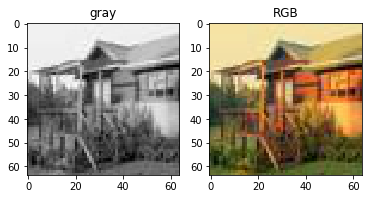

In [53]:
index = 45
X = train_set_x_orig[index]
Y = train_set_y_orig[index]

imgGray = X / 100 *255.
imgRGB = mlab2rgb(X, Y)

plt.subplot(1,2,1)
plt.title("gray")
plt.imshow(imgGray.astype(np.uint8), cmap ='gray')

plt.subplot(1,2,2)
plt.title("RGB")
plt.imshow(imgRGB.astype(np.uint8))

In [54]:
print("Number of training examples:" + str(trainNum))
print("Number of testing examples:" + str(testNum))
print("train_set_x_orig: " + str(train_set_x_orig.shape))
print("train_set_y_orig: " + str(train_set_y_orig.shape))
print("test_set_x_orig: " + str(test_set_x_orig.shape))
print("test_set_y_orig: " + str(test_set_y_orig.shape))

Number of training examples:400
Number of testing examples:100
train_set_x_orig: (400, 64, 64)
train_set_y_orig: (400, 64, 64, 2)
test_set_x_orig: (100, 64, 64)
test_set_y_orig: (100, 64, 64, 2)


In [55]:
# def softmax(x):
    
#     x_exp = np.exp(x)
#     x_sum = np.sum(x_exp, axis = 1, keepdims = True)
#     s = x_exp/x_sum
#     cache = x
#     return s, cache

In [56]:
# def softmax_backward(dA, cache):
#     return dA, cache

In [57]:
def zero_pad(X, pad):
    X_pad = np.pad(X,((0,0), (pad, pad), (pad, pad)),'constant', constant_values = (0,0))
    return X_pad

In [ ]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z +=float(b)
    
    return Z

In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) =W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev + 2 * pad - f) / stride) + 1
    n_W = int((n_W_prev + 2 * pad - f) / stride) + 1
    
    z = np.zeros((n, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start +f
                    horiz_start = stride *w
                    horiz_end = horiz_start +f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [ ]:
def pool_forward(A_prev, hparameters, mode = "average"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_h, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride *h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start +f
                    
                    a_prev_slice = A_prev[i, vert_start: vert_end, horiz_start:horiz_end, c]
                    
                    if mode =="max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.average(a_prev_slice)
                        
    cache = (A_prev, hparameters)
    
    return A, cache

In [ ]:
def conv_backward(dZ, cache):
    
    (A_prev, W, b, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1,1,1,n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H_prev):
            for w in range(n_W_prev):
                for c in range(n_C):
                    vert_start = stride*h
                    vert_end = vert_start + f
                    horiz_start = stride *w
                    horiz_end = horiz_start +f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    da_prev_pad[vert_start: vert_end, horiz_start: horiz_end, :] +=W[:,:,:,c] * dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
                
        dA_prev[i,:,:,:] = da_prev_pad[pad: -pad,pad:-pad,:]
        
        return dA_prev, dW, db
    

In [58]:
def flat_stan(x):
    set_x_flatten = x.reshape(x.shape[0],-1).T
    stan_x = set_x_flatten/100.
    return stan_x

In [59]:
def de_flat_stan(imgArr, dims = "l"):
    f_x = imgArr * 100.
    if dims == 'l':
        x = f_x.reshape(64,64)
    if dims =="ab":
        x = f_x.reshape(64, 64, 2)
    return x

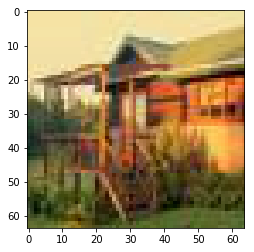

In [60]:
X2 = de_flat_stan(train_x[:, index], 'l')
Y2 = de_flat_stan(train_y[:, index], 'ab')
pimg = mlab2rgb(X2, Y2)
plt.imshow(pimg.astype(np.uint8))

In [61]:
train_x = flat_stan(train_set_x_orig)
train_y = flat_stan(train_set_y_orig)
test_x = flat_stan(test_set_x_orig)
test_y = flat_stan(test_set_y_orig)

print("train_x shape: ", train_x.shape)
print("train_y shape: ", train_y.shape)
print("test_x shape: ", test_x.shape)
print("test_y shape: ", test_y.shape)

train_x shape:  (4096, 400)
train_y shape:  (8192, 400)
test_x shape:  (4096, 100)
test_y shape:  (8192, 100)


In [62]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, 
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [63]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        #print("W" + str(l))
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [64]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    cache = (A, W, b)
    return Z, cache

In [65]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

In [66]:
def sigmoid(Z): 
    A = 1/(1+np.exp(-Z))
    cache=Z
    return A, cache

In [67]:
def linear_activation_forward(A_prev, W, b, activation):
#     if activation == "softmax":
#         Z, linear_cache = linear_forward(A_prev, W, b)
#         A, activation_cache = softmax(Z)
    
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

In [68]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
    
    return AL, caches

In [69]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = 1/m * np.sum(1/2*np.square(AL - Y))
    return cost

In [70]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis =1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [71]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z<=0] = 0
    return dZ

In [72]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [73]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db
        

In [74]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - 1/m*(Y-AL)
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid"
                                                                                                   )
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads
        

In [75]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - np.multiply(learning_rate, grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    return parameters

In [76]:
n_x = 4096
n_y = 8192
layers_dims = (n_x, 5120, 6144, 7168, n_y)

In [81]:
def L_layer_model(X,Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    
    costs = []

    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
                
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
        if i%100 == 0 and i>=100:
            learning_rate /=2
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
        
    return parameters

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 1, num_iterations = 500, print_cost = True)

Cost after iteration 0: 967.6982647449848


In [73]:
for para in parameters:
    np.savetxt('parameters/'+str(para)+'.csv', parameters[para], delimiter = ',')

In [90]:
def predict(X, Y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2      
    trans, caches = L_model_forward(X, parameters)
    
    return trans
    
#     plt.subplot(1,3,1)
#     plt.title("origin")
#     plt.imshow(test_set_x_orig[index].astype(np.uint8), cmap ='gray')
    
#     print(AL.shape)
    
#     plt.subplot(1,3,2)
#     plt.title("predict")
#     plt.imshow(de_flat_stan(AL).astype(np.uint8))
    
    
    
#     plt.subplot(1,3,3)
#     plt.title("True")
#     plt.imshow(test_set_y_orig[index].astype(np.uint8))

In [91]:
trans_img = predict(test_x, test_y, parameters)

In [97]:
def print_contrast(index, trans_img):
    plt.subplot(1,3,1)
    plt.title("origin")
    X1 = test_set_x_orig[index]/ 100 *255.
    plt.imshow(X1.astype(np.uint8), cmap ='gray')
    
    plt.subplot(1,3,2)
    plt.title("predict")  
    X2 = de_flat_stan(test_x[:, index], 'l')
    Y2 = de_flat_stan(trans_img[:, index], 'ab')
    pimg = mlab2rgb(X2, Y2)
    plt.imshow(pimg.astype(np.uint8))
        
    plt.subplot(1,3,3)
    plt.title("True")
    X3 = test_set_x_orig[index]
    Y3 = test_set_y_orig[index]
    timg = mlab2rgb(X3,Y3)
    plt.imshow(timg.astype(np.uint8))

(12288,)


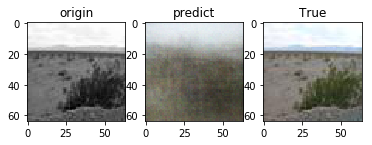

In [96]:
index =78
print_contrast(index, trans_img)